In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 150
from scipy.io import savemat
from tenpy.tools.params import get_parameter
from matplotlib import colors
import sys
from tenpy.models.lattice import Lattice

/Users/gleb/TeNPy/tenpy/tools/optimization.py:307: UserWarning: Couldn't load compiled cython code. Code will run a bit slower.
  warnings.warn("Couldn't load compiled cython code. Code will run a bit slower.")


In [2]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
tenpy.tools.misc.setup_logging(to_stdout="INFO")
import pickle

In [3]:
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.algorithms import dmrg

from tenpy.networks.site import SpinSite, SpinHalfSite, SpinHalfFermionSite, FermionSite
from tenpy.models.lattice import Triangular, Square, Chain
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel, CouplingMPOModel

In [4]:
''' Fermi-Hubbard model '''

class Spinless_real(CouplingModel, MPOModel):
    def __init__(self, model_param):
        
        ''' system size '''
        Lx = model_param["Lx"]
        Ly = model_param["Ly"]
        
        ''' coupling constants'''
        t = model_param["t"]
        V = model_param["V"]
                
        ''' boundary conditions'''
        bc_MPS = model_param["bc_MPS"]
        bc_y = model_param["bc_y"]
        bc_x = model_param["bc_x"]
        
        ''' site with particle + U(1) symmetry conservation'''
        site = FermionSite(conserve='N', filling = 0.5)
        
        ''' define triangular lattice'''
        lat = Triangular(Lx, Ly, site, bc=[bc_x, bc_y], bc_MPS=bc_MPS)   
        
        CouplingModel.__init__(self, lat)
        
        dR1 = [1,0]
        dR2 = [0,1]
        dR2m1 = [1,-1]
        
        if model_param["flux"]:
            
            '''hoppings along x'''
            hops_along_x = (-t) * np.array([[-1j] * Ly, [-1j] * Ly])
            self.add_coupling(hops_along_x, 0, 'Cd', 0,'C', dR1, plus_hc=True)
            
            ''' density-density interaction along x'''
            self.add_coupling(V, 0, 'N', 0,'N', dR1)
            
            
            
            '''hoppings along y'''
            hops_along_y = (-t) * np.array([[1] * Ly, [-1] * Ly])
            self.add_coupling(hops_along_y,0,'Cd',0,'C',dR2, plus_hc=True)
            
            ''' density-density interaction along y'''
            self.add_coupling(V, 0, 'N', 0,'N', dR2)
            
            
            '''hoppings along diag'''
            hops_diag = (-t) * np.array([[-1] * Ly, [1] * Ly])
            self.add_coupling(hops_diag,0,'Cd',0,'C', dR2m1, plus_hc=True)
            
            ''' density-density interaction along diag'''
            self.add_coupling(V, 0, 'N', 0,'N', dR2m1)
        
        else:
            
            '''hoppings along x'''
            hops_along_x = (-t) 
            self.add_coupling(hops_along_x, 0, 'Cd', 0,'C', dR1, plus_hc=True)
            
            ''' density-density interaction along x'''
            self.add_coupling(V, 0, 'N', 0,'N', dR1)
            
            
            
            '''hoppings along y'''
            hops_along_y = (-t) 
            self.add_coupling(hops_along_y,0,'Cd',0,'C',dR2, plus_hc=True)
            
            ''' density-density interaction along y'''
            self.add_coupling(V, 0, 'N', 0,'N', dR2)
            
            
            '''hoppings along diag'''
            hops_diag = (-t) 
            self.add_coupling(hops_diag,0,'Cd',0,'C', dR2m1, plus_hc=True)
            
            ''' density-density interaction along diag'''
            self.add_coupling(V, 0, 'N', 0,'N', dR2m1)
            

        MPOModel.__init__(self, lat, self.calc_H_MPO())
        
        ax = plt.gca()
        lat.plot_sites(ax)
        lat.plot_coupling(ax, lat.pairs['next_nearest_neighbors'], linestyle=':', color='r')

In [5]:
# if flux = True, put Lx = 2
# if flux = False, put Lx = 1

model_param = {"Lattice" : Triangular,
              "Ly" : 6,
              "Lx" : 1,
              "t" : 1.0,
              "V" : 15.0,
              "fraction" : 2,
              "bc_MPS" : "infinite",
              "bc_y" : 'periodic',
              "bc_x" : 'periodic',
              "flux" : False}

# chi_list = tenpy.algorithms.dmrg.chi_list(1000, dchi=500, nsweeps=20)
chi_list = {0:200, 20:500, 40:1000}
dmrg_params = {"trunc_params": {"chi_max": 1000, "svd_min": 1.e-10}, "mixer": True, "chi_list" : chi_list,"max_sweeps": 90}

In [6]:
chi_list

{0: 200, 20: 500, 40: 1000}

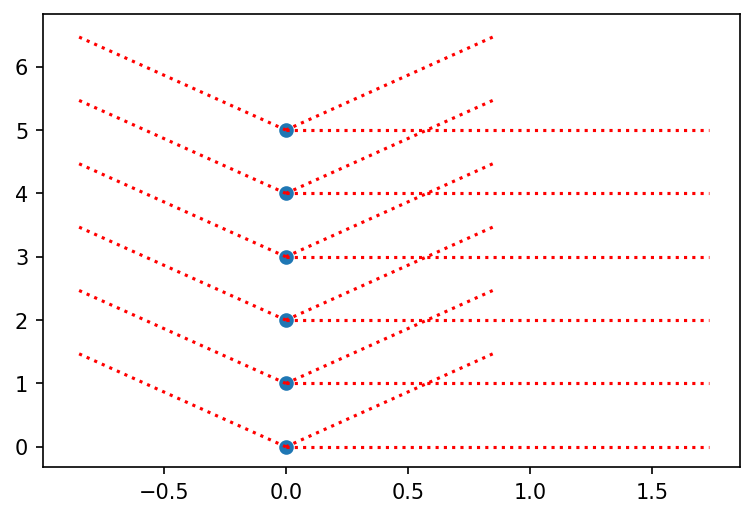

In [7]:
M = Spinless_real(model_param)
sites = M.lat.mps_sites()
psi = MPS.from_product_state(sites,["full","empty","empty"]*2,"infinite")

In [18]:
# print hopping terms
print(M.all_coupling_terms().to_TermList())

-1.00000 * Cd JW_0 C_1 +
-1.00000 * Cd JW_0 C_5 +
-1.00000 * Cd JW_0 C_6 +
-1.00000 * Cd JW_0 C_11 +
-1.00000 * JW C_0 Cd_1 +
-1.00000 * JW C_0 Cd_5 +
-1.00000 * JW C_0 Cd_6 +
-1.00000 * JW C_0 Cd_11 +
15.00000 * N_0 N_1 +
15.00000 * N_0 N_5 +
15.00000 * N_0 N_6 +
15.00000 * N_0 N_11 +
-1.00000 * Cd JW_1 C_2 +
-1.00000 * Cd JW_1 C_6 +
-1.00000 * Cd JW_1 C_7 +
-1.00000 * JW C_1 Cd_2 +
-1.00000 * JW C_1 Cd_6 +
-1.00000 * JW C_1 Cd_7 +
15.00000 * N_1 N_2 +
15.00000 * N_1 N_6 +
15.00000 * N_1 N_7 +
-1.00000 * Cd JW_2 C_3 +
-1.00000 * Cd JW_2 C_7 +
-1.00000 * Cd JW_2 C_8 +
-1.00000 * JW C_2 Cd_3 +
-1.00000 * JW C_2 Cd_7 +
-1.00000 * JW C_2 Cd_8 +
15.00000 * N_2 N_3 +
15.00000 * N_2 N_7 +
15.00000 * N_2 N_8 +
-1.00000 * Cd JW_3 C_4 +
-1.00000 * Cd JW_3 C_8 +
-1.00000 * Cd JW_3 C_9 +
-1.00000 * JW C_3 Cd_4 +
-1.00000 * JW C_3 Cd_8 +
-1.00000 * JW C_3 Cd_9 +
15.00000 * N_3 N_4 +
15.00000 * N_3 N_8 +
15.00000 * N_3 N_9 +
-1.00000 * Cd JW_4 C_5 +
-1.00000 * Cd JW_4 C_9 +
-1.00000 * Cd JW_4 C_10 

In [19]:
# print on-site terms
print(M.all_onsite_terms().to_TermList())

In [8]:
info = dmrg.run(psi, M, dmrg_params)
energy = info['E']
delta_energy = abs(info["sweep_statistics"]['E'][-1] - info["sweep_statistics"]['E'][-2])

INFO    : DMRG: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO    : DMRG: reading 'chi_list'={0: 200, 20: 500, 40: 1000}
INFO    : start environment_sweep
INFO    : trunc_params: reading 'chi_max'=1000
INFO    : trunc_params: reading 'svd_min'=1e-10
INFO    : DMRG: reading 'max_sweeps'=90
INFO    : DMRG: reading 'mixer'=True
INFO    : activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO    : Running sweep with optimization
INFO    : activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO    : Setting chi_max=200
INFO    : start environment_sweep
INFO    : checkpoint after sweep 10
energy=7.5114860987873540, max S=1.2478682790706055, age=198, norm_err=1.4e-01
Current memory usage 201084.0MB, wall time: 129.2s
Delta E = nan, Delta S = 1.1719e-01 (per sweep)
max trunc_err = 6.9866e-09, max E_trunc = 1.4672e-08
chi: [200, 200, 200, 200, 200, 200]
INFO    : Running sweep with optimization
INFO    : disable mixer after 15 sweeps, final amplitude 3.05e-10

In [15]:
dist = np.arange(0, 30)

In [16]:
charge_corr = psi.correlation_function(ops1 = "N", ops2 = "N", sites1 = [0], sites2 = dist)[0]

Text(0, 0.5, '<$n_i n_j$>')

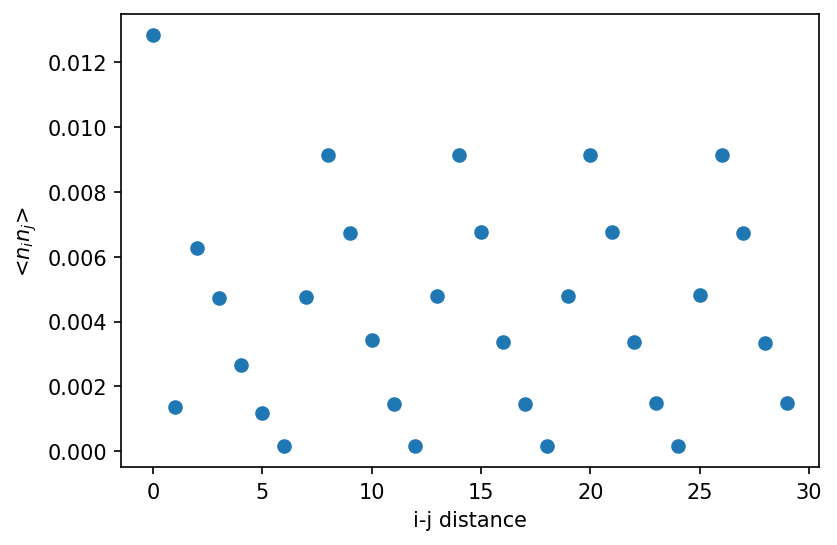

In [17]:
plt.scatter(dist, charge_corr)
plt.xlabel('i-j distance')
plt.ylabel('<$n_i n_j$>')

In [12]:
# Ly =6, Lx = 2, t = 1, U = 3, chi_max = 500, E = -0.1965750299511294 Delta E = 7.0071e-05

In [13]:
# with open('data_spinless_real_U_3.0.pkl', 'rb')  as f:
#     data_load = pickle.load(f)

# data_load['Delta Energy']

In [14]:
# SPINLESS REAL
# t = 1.57, U =0, ["full","full","empty","empty","empty","empty"]: 
# E = -1.37285904, Delta_E = -3.4541e-03